In [1]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
DATA_PATH = Path("/Users/nadaashraf/Heart_Disease_Project/data/heart_selected_features.csv")
df = pd.read_csv(DATA_PATH)


In [3]:

X = df.drop(columns=["num"])
y = (df["num"] > 0).astype(int)  # binary: 0 healthy, 1 disease



In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((736, 13), (184, 13))

In [5]:
#tune the logistic regression model 
param_grid_lr = {
    "C": [0.01, 0.1, 1, 3, 10],
    "penalty": ["l1", "l2"],
    "class_weight": ["balanced"],  # keep consistent with earlier training
    "solver": ["liblinear"],
    "max_iter": [1000]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid_lr,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    refit=True
)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
print("Best LR params:", grid_lr.best_params_)
print("Best LR CV AUC:", grid_lr.best_score_)

# test-set evaluation
y_pred_lr  = best_lr.predict(X_test)
y_prob_lr  = best_lr.predict_proba(X_test)[:,1]
lr_metrics = {
    "Model": "LogisticRegression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, zero_division=0),
    "F1": f1_score(y_test, y_pred_lr, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, y_prob_lr),
}
lr_metrics


Best LR params: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Best LR CV AUC: 0.8819357918002904


{'Model': 'LogisticRegression',
 'Accuracy': 0.8206521739130435,
 'Precision': 0.8349514563106796,
 'Recall': 0.8431372549019608,
 'F1': 0.8390243902439024,
 'ROC_AUC': 0.9062649450023913}

In [6]:
#tuning the random forest model
param_dist_rf = {
    "n_estimators": [150, 250, 300, 400, 600],
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

rand_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,        # try 30 random combos
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    random_state=42,
    refit=True
)
rand_rf.fit(X_train, y_train)

best_rf = rand_rf.best_estimator_
print("Best RF params:", rand_rf.best_params_)
print("Best RF CV AUC:", rand_rf.best_score_)

# test-set evaluation
y_pred_rf  = best_rf.predict(X_test)
y_prob_rf  = best_rf.predict_proba(X_test)[:,1]
rf_metrics = {
    "Model": "RandomForest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf, zero_division=0),
    "Recall": recall_score(y_test, y_pred_rf, zero_division=0),
    "F1": f1_score(y_test, y_pred_rf, zero_division=0),
    "ROC_AUC": roc_auc_score(y_test, y_prob_rf),
}
rf_metrics


Best RF params: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'class_weight': 'balanced'}
Best RF CV AUC: 0.8826292456915763


{'Model': 'RandomForest',
 'Accuracy': 0.8478260869565217,
 'Precision': 0.8627450980392157,
 'Recall': 0.8627450980392157,
 'F1': 0.8627450980392157,
 'ROC_AUC': 0.9158297465327594}

In [7]:
results = pd.DataFrame([lr_metrics, rf_metrics]).sort_values("ROC_AUC", ascending=False)
results


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,RandomForest,0.847826,0.862745,0.862745,0.862745,0.915830
0,LogisticRegression,0.820652,0.834951,0.843137,0.839024,0.906265


In [8]:
# choose the best model by ROC_AUC 
best_row = results.sort_values(["ROC_AUC","F1"], ascending=False).iloc[0]
winner_name = best_row["Model"]
winner = best_lr if winner_name == "LogisticRegression" else best_rf
print(f" Best model: {winner_name}\n{best_row.to_dict()}")


 Best model: RandomForest
{'Model': 'RandomForest', 'Accuracy': 0.8478260869565217, 'Precision': 0.8627450980392157, 'Recall': 0.8627450980392157, 'F1': 0.8627450980392157, 'ROC_AUC': 0.9158297465327594}


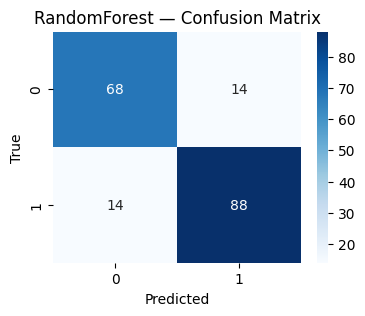

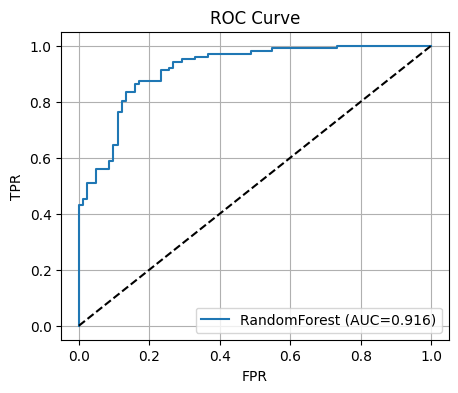

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_pred = winner.predict(X_test)
y_prob = winner.predict_proba(X_test)[:,1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"{winner_name} — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"{winner_name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
plt.legend(); plt.grid(True); plt.show()


In [10]:
models_dir = Path("/Users/nadaashraf/Heart_Disease_Project/models"); models_dir.mkdir(exist_ok=True, parents=True)
report_path = Path("/Users/nadaashraf/Heart_Disease_Project/results/evaluation_metrics.txt")

joblib.dump(winner, models_dir / "final_model.pkl")

with report_path.open("a") as f:
    f.write("\n\n=== Hyperparameter Tuning (Binary) ===\n")
    f.write(results.to_string(index=False))

print("Saved model to:", (models_dir / "final_model.pkl").resolve())
print("Appended metrics to:", report_path.resolve())


Saved model to: /Users/nadaashraf/Heart_Disease_Project/models/final_model.pkl
Appended metrics to: /Users/nadaashraf/Heart_Disease_Project/results/evaluation_metrics.txt


In [11]:

from pathlib import Path
import json
import joblib
import pandas as pd
import numpy as np

# Paths
DATA_PATH   = Path("../data/heart_selected_features.csv")
MODELS_DIR  = Path("../models"); MODELS_DIR.mkdir(exist_ok=True, parents=True)
FINAL_PKL   = MODELS_DIR / "final_model.pkl"           # already saved earlier
PIPELINE_PKL= MODELS_DIR / "model_pipeline.pkl"        # we'll save now
META_JSON   = MODELS_DIR / "model_metadata.json"

# Final medical-only features used for supervised learning 
FINAL_FEATURES = [
    "age", "sex_Male", "chol", "trestbps", "thalach", "oldpeak", "ca",
    "exang", "cp_non-anginal", "cp_atypical angina", "cp_typical angina",
    "thal_normal", "thal_reversable defect"
]

# Split into continuous vs binary
NUMERIC_COLS = ["age", "chol", "trestbps", "thalach", "oldpeak", "ca"]
BINARY_COLS  = [c for c in FINAL_FEATURES if c not in NUMERIC_COLS]

# If X_train / X_test aren't in memory, rebuild them quickly (binary target)
try:
    X_train
    X_test
    y_train
    y_test
except NameError:
    assert DATA_PATH.exists(), f"Missing {DATA_PATH}"
    _df = pd.read_csv(DATA_PATH)
    _X = _df.drop(columns=["num"])
    _y = (_df["num"] > 0).astype(int)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        _X, _y, test_size=0.2, stratify=_y, random_state=42
    )

# Get the tuned winner estimator 
try:
    winner
except NameError:
    assert FINAL_PKL.exists(), f"Missing {FINAL_PKL}; run tuning cells above first."
    winner = joblib.load(FINAL_PKL)

type(winner), FINAL_PKL.exists()


(sklearn.ensemble._forest.RandomForestClassifier, True)

In [17]:
# --- FIX COLUMN NAMES + SANITY CHECK ---

# candidate names for the max heart rate column
candidates_thalach = ["thalach", "thalch"]

# detect which one exists in X_train
present_thalach = [c for c in candidates_thalach if c in X_train.columns]
assert len(present_thalach) >= 1, "Neither 'thalach' nor 'thalch' found in X_train columns!"
HEARTRATE_COL = present_thalach[0]  # pick the one that exists

# Final medical-only features (use the detected heart-rate column)
FINAL_FEATURES = [
    "age", "sex_Male", "chol", "trestbps", HEARTRATE_COL, "oldpeak", "ca",
    "exang", "cp_non-anginal", "cp_atypical angina", "cp_typical angina",
    "thal_normal", "thal_reversable defect"
]

# Split into continuous vs binary/dummies
NUMERIC_COLS = ["age", "chol", "trestbps", HEARTRATE_COL, "oldpeak", "ca"]
BINARY_COLS  = [c for c in FINAL_FEATURES if c not in NUMERIC_COLS]

# Check presence of every feature in the dataframe
missing = [c for c in FINAL_FEATURES if c not in X_train.columns]
extra   = [c for c in X_train.columns if c not in FINAL_FEATURES + ["num"]]

print("Heart-rate column chosen:", HEARTRATE_COL)
print("Missing features:", missing)
print("Extra features (ignored):", extra)

# hard assert to avoid silent failures
assert not missing, f"These expected features are missing from X_train: {missing}"


Heart-rate column chosen: thalch
Missing features: []
Extra features (ignored): []


In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUMERIC_COLS),
        ("bin", "passthrough", BINARY_COLS),
    ],
    remainder="drop"
)

final_estimator = clone(winner)
pipe = Pipeline([("preprocess", preprocess), ("model", final_estimator)])

pipe.fit(X_train[FINAL_FEATURES], y_train)   # <-- should work now


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
from sklearn.metrics import roc_auc_score

# Save pipeline
joblib.dump(pipe, PIPELINE_PKL)
print("Saved pipeline to:", PIPELINE_PKL.resolve())

# Save small metadata for traceability
meta = {
    "features": FINAL_FEATURES,
    "numeric_cols": NUMERIC_COLS,
    "binary_cols": BINARY_COLS,
    "model_class": type(final_estimator).__name__,
    "model_params": final_estimator.get_params(),
}
with open(META_JSON, "w") as f:
    json.dump(meta, f, indent=2)
print(" Saved metadata to:", META_JSON.resolve())

# Quick evaluation with the just-fitted pipeline (AUC on test set)
proba_pipe = pipe.predict_proba(X_test[FINAL_FEATURES])[:, 1]
print("Pipeline ROC_AUC (test):", roc_auc_score(y_test, proba_pipe))


Saved pipeline to: /Users/nadaashraf/Heart_Disease_Project/models/model_pipeline.pkl
 Saved metadata to: /Users/nadaashraf/Heart_Disease_Project/models/model_metadata.json
Pipeline ROC_AUC (test): 0.913558106169297


In [20]:
pipe_loaded = joblib.load(PIPELINE_PKL)
proba_loaded = pipe_loaded.predict_proba(X_test[FINAL_FEATURES])[:, 1]

from sklearn.metrics import roc_auc_score
print("Loaded pipeline ROC_AUC (test):", roc_auc_score(y_test, proba_loaded))

Loaded pipeline ROC_AUC (test): 0.913558106169297
